In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from Training import model, utils, dataset, train
import numpy as np
from sklearn import preprocessing
from IPython.display import HTML
from matplotlib import animation
from mpl_toolkits.mplot3d import axes3d

In [2]:
test_model_1 = model.Model500RELUBNResidual()
# load data 1066 data 
data1 = utils.parseGainAndBWCsv('Data/BW_Gain324.csv')
data2 = utils.parseGainAndBWCsv('Data/BW_Gain322.csv')
data3 = utils.parseGainAndBWCsv('Data/BW_Gain2.0.csv')
data4 = utils.parseGainAndBWCsv('Data/BW_Gain324_1.csv')
data1 += data2
data1 += data3
data1 += data4
print(len(data1))
prune_data = utils.get_rid_of_duplicate(data1)
count, prune_data = utils.check_same_x_different_y(prune_data)
data = np.array(prune_data).astype(float)
#data = np.array(data1).astype(float)

3736
([4e-06, 1003.5], [9.299, 3.75]) ([4e-06, 1003.5], [9.293, 3.75])
([4e-06, 1005.5], [9.31, 3.74]) ([4e-06, 1005.5], [9.304, 3.75])
([4e-06, 1007.5], [9.321, 3.74]) ([4e-06, 1007.5], [9.315, 3.74])
([4e-06, 1019.5], [9.386000000000001, 3.7]) ([4e-06, 1019.5], [9.38, 3.7])
([4e-06, 1020.0], [9.388, 3.69]) ([4e-06, 1020.0], [9.383, 3.7])
([4.01e-06, 1019.5], [9.396, 3.69]) ([4.01e-06, 1019.5], [9.391, 3.69])
([4.01e-06, 1020.0], [9.399, 3.69]) ([4.01e-06, 1020.0], [9.394, 3.69])
([4.02e-06, 1019.5], [9.407, 3.68]) ([4.02e-06, 1019.5], [9.402000000000001, 3.69])
([4.02e-06, 1020.0], [9.41, 3.68]) ([4.02e-06, 1020.0], [9.405, 3.68])
([4.02e-06, 1008.5], [9.353, 3.71]) ([4.02e-06, 1008.5], [9.343, 3.72])
([4.02e-06, 1019.5], [9.413, 3.68]) ([4.02e-06, 1019.5], [9.402000000000001, 3.69])
([4.02e-06, 1020.0], [9.415, 3.68]) ([4.02e-06, 1020.0], [9.405, 3.68])
([4.03e-06, 1019.5], [9.424, 3.67]) ([4.03e-06, 1019.5], [9.418, 3.68])
([4.03e-06, 1020.0], [9.426, 3.67]) ([4.03e-06, 1020.0], [9

In [3]:
print(data.shape)


(1649, 2, 2)


In [4]:
data = data.reshape(data.shape[0],4)
feature = data.T[0]

### OLD NORM CODE ###
# #ensure norm and denorm work 
# norm, data_min, data_max = utils.normalize(feature)
# feature_1 = utils.denormalize(norm, data_min, data_max)


# min_max = dict()
# for i in range(4):
#     feature = data.T[i]
#     norm_feature, data_min, data_max = utils.normalize(feature)
#     data.T[i] = norm_feature
#     min_max[i] = [data_min, data_max]
# norm_data, min_max = utils.normalize(data)
# denorm__data = utils.denormalize(norm_data, min_max)
### END OLD NORM CODE ###

norm_data, min_max = utils.normalize(data)
denorm_data = utils.denormalize(norm_data, min_max)
data = norm_data.reshape(norm_data.shape[0],2,2)

#data = data.reshape(data.shape[0],2,2)

In [5]:
data_x = data[:, 1]
data_y = data[: ,0]
data_set = dataset.CircuitSynthesisGainAndBandwidthManually(data_x, data_y)

In [6]:
train_dataset, val_dataset = utils.splitDataset(data_set, 0.8)

In [7]:
dtype = torch.FloatTensor
loss_fn = nn.L1Loss().type(dtype)  # loss can be changed here. This is the first one i tried that gave meaningful results

x = optim.Adam
optimizer1 = x(test_model_1.parameters(), lr=3e-4)#0.06448295999961791)  # TODO haven't experimented with this yet
train_data = DataLoader(train_dataset, batch_size=250)
test_data = DataLoader(val_dataset, batch_size = 50)

In [8]:
total_train = len(train_dataset)
total_test = len(val_dataset)

In [9]:
ta5 = []
ta10 = []
ta20 = []
va5 = []
va10 = []
va20 = []
train_loss = []
for epoch in range(1000):
    #print('Starting epoch %d / %d' % (epoch + 1, num_epochs))

    avg_loss = 0
        
    test_model_1.train()
    for t, (x, y) in enumerate(train_data):

        x_var = torch.autograd.Variable(x.type(dtype))
        y_var = torch.autograd.Variable(y.type(dtype).float())

        # make predictions
        scores = test_model_1(x_var)

        loss = loss_fn(scores.float(), y_var.float())
        avg_loss += (loss.item() - avg_loss) / (t+1)
        
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
    
    print('t = %d, loss = %.4f' % (epoch + 1, avg_loss))
    
    train_loss.append(avg_loss)
    vacc5, _,_ = train.check_raw_accuracy(test_model_1, test_data, min_max, .05, verbose=False)
    vacc10, _,_ = train.check_raw_accuracy(test_model_1, test_data, min_max, .1, verbose=False)
    vacc20, _,_ = train.check_raw_accuracy(test_model_1, test_data, min_max, .2, verbose=False)
    tacc5, _,_ = train.check_raw_accuracy(test_model_1, train_data, min_max, .05, verbose=False)
    tacc10, _,_ = train.check_raw_accuracy(test_model_1, train_data, min_max, .1, verbose=False)
    tacc20, _,_ = train.check_raw_accuracy(test_model_1, train_data, min_max, .2, verbose=False)
    
    ta5.append(tacc5)
    ta10.append(tacc10)
    ta20.append(tacc20)
    va5.append(vacc5)
    va10.append(vacc10)
    va20.append(vacc20)


t = 1, loss = 0.3200
t = 2, loss = 0.1284
t = 3, loss = 0.1121
t = 4, loss = 0.1024
t = 5, loss = 0.0930
t = 6, loss = 0.0869
t = 7, loss = 0.0817
t = 8, loss = 0.0789
t = 9, loss = 0.0765
t = 10, loss = 0.0745
t = 11, loss = 0.0737
t = 12, loss = 0.0767
t = 13, loss = 0.0735
t = 14, loss = 0.0729
t = 15, loss = 0.0690
t = 16, loss = 0.0703
t = 17, loss = 0.0702
t = 18, loss = 0.0682
t = 19, loss = 0.0669
t = 20, loss = 0.0676
t = 21, loss = 0.0729
t = 22, loss = 0.0717
t = 23, loss = 0.0682
t = 24, loss = 0.0705
t = 25, loss = 0.0659
t = 26, loss = 0.0619
t = 27, loss = 0.0631
t = 28, loss = 0.0624
t = 29, loss = 0.0638
t = 30, loss = 0.0647
t = 31, loss = 0.0621
t = 32, loss = 0.0643
t = 33, loss = 0.0603
t = 34, loss = 0.0607
t = 35, loss = 0.0598
t = 36, loss = 0.0602
t = 37, loss = 0.0634
t = 38, loss = 0.0622
t = 39, loss = 0.0625
t = 40, loss = 0.0636
t = 41, loss = 0.0617
t = 42, loss = 0.0564
t = 43, loss = 0.0534
t = 44, loss = 0.0532
t = 45, loss = 0.0543
t = 46, loss = 0.05

t = 362, loss = 0.0350
t = 363, loss = 0.0328
t = 364, loss = 0.0329
t = 365, loss = 0.0330
t = 366, loss = 0.0367
t = 367, loss = 0.0362
t = 368, loss = 0.0349
t = 369, loss = 0.0344
t = 370, loss = 0.0346
t = 371, loss = 0.0360
t = 372, loss = 0.0371
t = 373, loss = 0.0369
t = 374, loss = 0.0339
t = 375, loss = 0.0344
t = 376, loss = 0.0345
t = 377, loss = 0.0347
t = 378, loss = 0.0333
t = 379, loss = 0.0347
t = 380, loss = 0.0350
t = 381, loss = 0.0350
t = 382, loss = 0.0357
t = 383, loss = 0.0366
t = 384, loss = 0.0338
t = 385, loss = 0.0350
t = 386, loss = 0.0361
t = 387, loss = 0.0361
t = 388, loss = 0.0359
t = 389, loss = 0.0356
t = 390, loss = 0.0338
t = 391, loss = 0.0356
t = 392, loss = 0.0375
t = 393, loss = 0.0363
t = 394, loss = 0.0365
t = 395, loss = 0.0351
t = 396, loss = 0.0335
t = 397, loss = 0.0352
t = 398, loss = 0.0350
t = 399, loss = 0.0356
t = 400, loss = 0.0323
t = 401, loss = 0.0325
t = 402, loss = 0.0343
t = 403, loss = 0.0362
t = 404, loss = 0.0347
t = 405, lo

t = 719, loss = 0.0269
t = 720, loss = 0.0289
t = 721, loss = 0.0282
t = 722, loss = 0.0280
t = 723, loss = 0.0268
t = 724, loss = 0.0282
t = 725, loss = 0.0302
t = 726, loss = 0.0291
t = 727, loss = 0.0282
t = 728, loss = 0.0268
t = 729, loss = 0.0279
t = 730, loss = 0.0273
t = 731, loss = 0.0279
t = 732, loss = 0.0283
t = 733, loss = 0.0263
t = 734, loss = 0.0279
t = 735, loss = 0.0272
t = 736, loss = 0.0289
t = 737, loss = 0.0265
t = 738, loss = 0.0269
t = 739, loss = 0.0283
t = 740, loss = 0.0272
t = 741, loss = 0.0283
t = 742, loss = 0.0289
t = 743, loss = 0.0278
t = 744, loss = 0.0285
t = 745, loss = 0.0277
t = 746, loss = 0.0277
t = 747, loss = 0.0266
t = 748, loss = 0.0291
t = 749, loss = 0.0311
t = 750, loss = 0.0285
t = 751, loss = 0.0264
t = 752, loss = 0.0264
t = 753, loss = 0.0262
t = 754, loss = 0.0283
t = 755, loss = 0.0276
t = 756, loss = 0.0294
t = 757, loss = 0.0264
t = 758, loss = 0.0246
t = 759, loss = 0.0257
t = 760, loss = 0.0252
t = 761, loss = 0.0278
t = 762, lo

t = 1073, loss = 0.0212
t = 1074, loss = 0.0217
t = 1075, loss = 0.0217
t = 1076, loss = 0.0213
t = 1077, loss = 0.0234
t = 1078, loss = 0.0231
t = 1079, loss = 0.0225
t = 1080, loss = 0.0228
t = 1081, loss = 0.0228
t = 1082, loss = 0.0219
t = 1083, loss = 0.0234
t = 1084, loss = 0.0241
t = 1085, loss = 0.0231
t = 1086, loss = 0.0237
t = 1087, loss = 0.0231
t = 1088, loss = 0.0231
t = 1089, loss = 0.0231
t = 1090, loss = 0.0216
t = 1091, loss = 0.0217
t = 1092, loss = 0.0223
t = 1093, loss = 0.0242
t = 1094, loss = 0.0245
t = 1095, loss = 0.0248
t = 1096, loss = 0.0227
t = 1097, loss = 0.0224
t = 1098, loss = 0.0234
t = 1099, loss = 0.0222
t = 1100, loss = 0.0222
t = 1101, loss = 0.0231
t = 1102, loss = 0.0245
t = 1103, loss = 0.0217
t = 1104, loss = 0.0230
t = 1105, loss = 0.0243
t = 1106, loss = 0.0221
t = 1107, loss = 0.0218
t = 1108, loss = 0.0228
t = 1109, loss = 0.0231
t = 1110, loss = 0.0237
t = 1111, loss = 0.0243
t = 1112, loss = 0.0233
t = 1113, loss = 0.0229
t = 1114, loss =

t = 1415, loss = 0.0193
t = 1416, loss = 0.0186
t = 1417, loss = 0.0198
t = 1418, loss = 0.0208
t = 1419, loss = 0.0212
t = 1420, loss = 0.0198
t = 1421, loss = 0.0195
t = 1422, loss = 0.0194
t = 1423, loss = 0.0198
t = 1424, loss = 0.0214
t = 1425, loss = 0.0222
t = 1426, loss = 0.0196
t = 1427, loss = 0.0221
t = 1428, loss = 0.0202
t = 1429, loss = 0.0191
t = 1430, loss = 0.0193
t = 1431, loss = 0.0194
t = 1432, loss = 0.0181
t = 1433, loss = 0.0193
t = 1434, loss = 0.0198
t = 1435, loss = 0.0189
t = 1436, loss = 0.0186
t = 1437, loss = 0.0198
t = 1438, loss = 0.0209
t = 1439, loss = 0.0190
t = 1440, loss = 0.0204
t = 1441, loss = 0.0220
t = 1442, loss = 0.0213
t = 1443, loss = 0.0202
t = 1444, loss = 0.0190
t = 1445, loss = 0.0188
t = 1446, loss = 0.0199
t = 1447, loss = 0.0189
t = 1448, loss = 0.0204
t = 1449, loss = 0.0201
t = 1450, loss = 0.0196
t = 1451, loss = 0.0198
t = 1452, loss = 0.0197
t = 1453, loss = 0.0201
t = 1454, loss = 0.0215
t = 1455, loss = 0.0202
t = 1456, loss =

t = 1757, loss = 0.0177
t = 1758, loss = 0.0180
t = 1759, loss = 0.0182
t = 1760, loss = 0.0185
t = 1761, loss = 0.0183
t = 1762, loss = 0.0187
t = 1763, loss = 0.0172
t = 1764, loss = 0.0169
t = 1765, loss = 0.0170
t = 1766, loss = 0.0167
t = 1767, loss = 0.0174
t = 1768, loss = 0.0177
t = 1769, loss = 0.0186
t = 1770, loss = 0.0193
t = 1771, loss = 0.0189
t = 1772, loss = 0.0177
t = 1773, loss = 0.0181
t = 1774, loss = 0.0171
t = 1775, loss = 0.0174
t = 1776, loss = 0.0175
t = 1777, loss = 0.0182
t = 1778, loss = 0.0173
t = 1779, loss = 0.0176
t = 1780, loss = 0.0189
t = 1781, loss = 0.0191
t = 1782, loss = 0.0178
t = 1783, loss = 0.0168
t = 1784, loss = 0.0170
t = 1785, loss = 0.0157
t = 1786, loss = 0.0175
t = 1787, loss = 0.0206
t = 1788, loss = 0.0190
t = 1789, loss = 0.0182
t = 1790, loss = 0.0176
t = 1791, loss = 0.0170
t = 1792, loss = 0.0177
t = 1793, loss = 0.0169
t = 1794, loss = 0.0169
t = 1795, loss = 0.0176
t = 1796, loss = 0.0169
t = 1797, loss = 0.0167
t = 1798, loss =

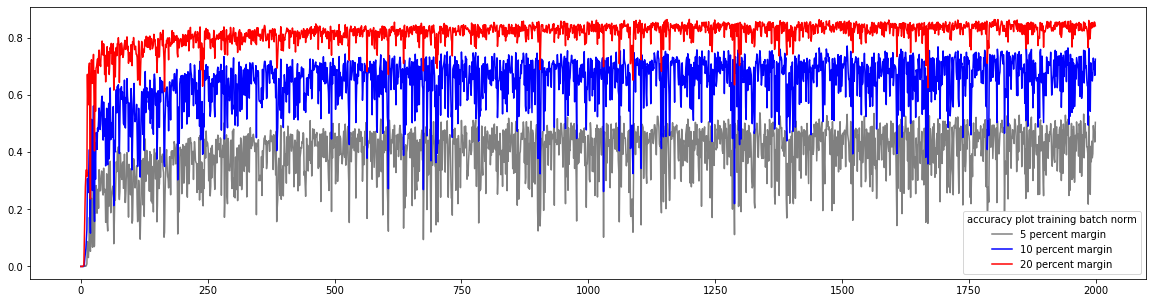

In [10]:
plt.figure(figsize = (20,5))
plt.plot(ta5, color='grey', label='5 percent margin')
plt.plot(ta10, color='blue', label = '10 percent margin')
plt.plot(ta20, color='red', label = '20 percent margin')
plt.legend(title = 'accuracy plot training batch norm')
plt.show()

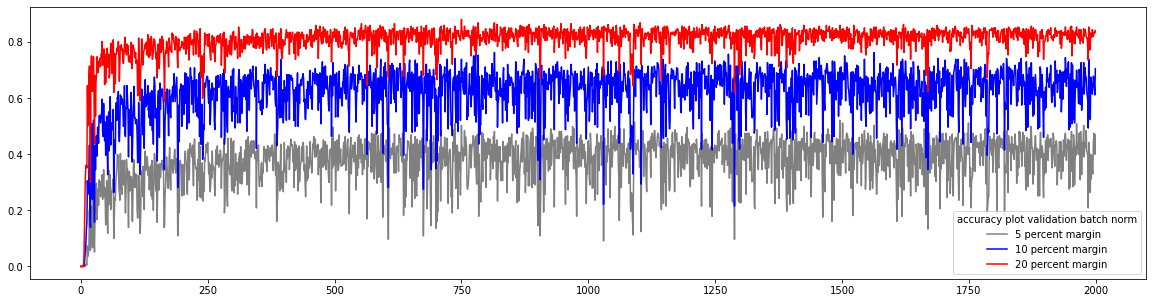

In [11]:
plt.figure(figsize=(20,5))
plt.plot(va5, color='grey', label='5 percent margin')
plt.plot(va10, color='blue', label = '10 percent margin')
plt.plot(va20, color='red', label = '20 percent margin')
plt.legend(title = 'accuracy plot validation batch norm')
plt.show()

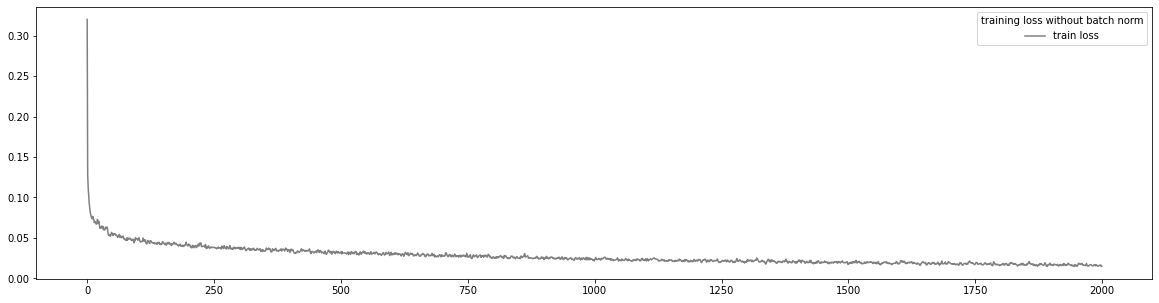

In [12]:
plt.figure(figsize=(20,5))
plt.plot(train_loss, color='grey', label='train loss')
plt.legend(title = 'training loss without batch norm')
plt.show()

In [13]:
max(va5)

0.5212121212121212

In [14]:
max(ta5)

0.5382865807429871

In [15]:
min_max

array([[ 1.000e-06,  1.000e-05],
       [ 2.000e+02,  2.010e+03],
       [-2.294e+00,  1.050e+01],
       [ 2.650e+00,  9.920e+00]])

In [29]:
min_max.shape

(4, 2)

In [41]:
# Each data point will be a tuple with a format of (Transistor width, resistor load, Bandwidth, Gain)
k = data_set[2]


In [42]:
x,y=k[0],k[1]

In [43]:
y = torch.tensor(y[None,:]).float()

In [44]:

y_hat = test_model_1(y)

In [45]:
x

array([0.90456464, 0.15268226])

In [46]:
y

tensor([[0.3333, 0.4425]])

In [53]:
y_n = utils.denormalize(y,min_max[2:,:])

In [55]:
x_n = utils.denormalize(x[None,:],min_max[0:2,:])

In [49]:
p = utils.denormalize(y_hat.detach().numpy(),min_max[2:,:])

In [50]:
def test_simulator(width, resistor):
    gain = 20 * math.log(abs(-1 * resistor * (49 * math.pow(10, -3) * 0.02302 * width / math.pow(10, -6) * 0.2)),10)
    bandwidth = 1/(2 * math.pi * resistor * 348.435)
    return gain, bandwidth

In [56]:
test_simulator(x_n[0,0], x_n[0,1])

(-0.15480780522120155, 9.588876763596288e-07)

In [57]:
y_n

array([[1.97066665, 5.86727619]])